# PyTraction demo

The following sections will demonstrate how to use the PyTraction python package. We will cover three examples:

1. Example 1 - basic usage an image stack and reference image in the correct format
2. Example 2 - basic usage with an ROI file
3. Example 3 - usage with data in an alternative format and automatic segmentation

Before starting this tutorial please ensure that you have install PyTraction

## Installation

Please make sure you have a version of conda (or miniconda) installed on your system and run the following commands.

```
git clone https://github.com/rg314/pytraction.git
conda create -n pytraction python=3.8
pip install pytraction/
cd pytraction
python scripts/get_example_data.py
pip install notebook
python -m ipykernel install --user --name=pytraction
python jupyter notebook
```


In [1]:
import numpy as np
from skimage import io
import matplotlib.pyplot as plt

from pytraction.core import TractionForce
from pytraction.utils import plot

## Example 1 

Basic example showing usage with and image stack and reference

In [2]:
pix_per_mu = 1.3 # The number of pixels per micron 
E = 100 # Youngs modulus in Pa

img_path = '../data/example1/e01_pos1_axon1.tif'
ref_path = '../data/example1/e01_pos1_axon1_ref.tif'

We can instantiate the traction force object ```TractionForce``` by passing the pixel per microns, Young’s modules (Pa), and minimum window size. The window size needs to be a multiple of base 2 i.e. 8, 16, 32, 64. From initial data we’ve found that a parameter between 8 and 64 will be suitable and depends on the bead density of the input images.

In [3]:
traction_obj = TractionForce(pix_per_mu, E=E, window_size=32) # config TractionForce object
img, ref, _ = traction_obj.load_data(img_path, ref_path) # we can load the dat using the load_data method

print(f'The expected shape of the image is {img.shape}')
print(f'The expected shape of the reference is {ref.shape}')

The expected shape of the image is (13, 2, 362, 641)
The expected shape of the reference is (2, 362, 641)


Notice the shape of the input image is ```(time, channels, width, height)``` and the reference is ```(channels, width, height)```. This is the expected format that the package takes so please ensure that your data is in this format. If you are having issues please contact us and we can give you advice on how to prepare your data.

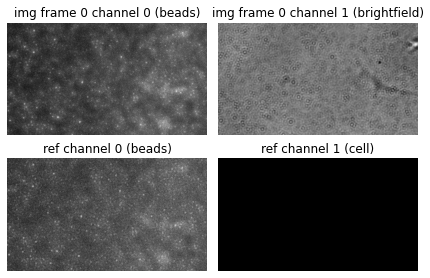

In [4]:
fig, ax = plt.subplots(2,2)
ax[0,0].set_title('img frame 0 channel 0 (beads)')
ax[0,0].imshow(img[0,0,:,:], cmap='gray')
ax[0,0].set_axis_off()

ax[0,1].set_title('img frame 0 channel 1 (brightfield)')
ax[0,1].imshow(img[0,1,:,:], cmap='gray')
ax[0,1].set_axis_off()

ax[1,0].set_title('ref channel 0 (beads)')
ax[1,0].imshow(ref[0,:,:], cmap='gray')
ax[1,0].set_axis_off()

ax[1,1].set_title('ref channel 1 (cell)')
ax[1,1].imshow(ref[1,:,:], cmap='gray')
ax[1,1].set_axis_off()

plt.tight_layout()

We can now process the stack to get the TFM results. We can set the verbose to 1 to stop any print statements. When the verbose is set to 0 the iterative PIV and the TFM function minimization.

In [5]:
log1 = traction_obj.process_stack(img, ref, verbose=1)

Processing stacks


/Users/ryan/miniconda3/envs/pytraction/lib/python3.8/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/Users/ryan/miniconda3/envs/pytraction/lib/python3.8/site-packages/scipy/optimize/optimize.py:1971: ComplexWarning: Casting complex values to real discards the imaginary part
  print("%5.0f   %12.6g %12.6g %s" % (fmin_data + (step,)))
/Users/ryan/miniconda3/envs/pytraction/lib/python3.8/site-packages/scipy/optimize/optimize.py:2015: ComplexWarning: Casting complex values to real discards the imaginary part
  print("%5.0f   %12.6g %12.6g %s" % (fmin_data + (step,)))


A pandas DataFrame with the following columns: 

| Columns       | Description |
| :----------- | :----------- |
| frame      | frame number       |
| traction_map   | (n, m) numpy.ndarray of traction stress in Pa |
| force_field   | (n, m, 2) numpy.ndarray of x and y force components  |
| stack_bead_roi   | (2, w, h) numpy.ndarray of image stack before and after deformation after alignment |
| cell_roi   | (w, h) numpy.ndarray of cell in frame |
| mask_roi   | (w, h) numpy.ndarray of binary mask 0 is background and 1 is cell |
| beta   | parameter quantifying the noise in the image |
| L   | optimized regularization parameter |
| pos   | (2, N) positions from PIV of x and y. N depends on the minimum window size |
| vec   | (2, N) displacement from PIV of U and V. N depends on the minimum window size |

In [6]:
log1.head(2)

,frame,traction_map,force_field,stack_bead_roi,cell_roi,mask_roi,beta,L,pos,vec
0,0,"[[0.26584239564587453, 0.28450512123426186, 0....","[[[0.02512601104896235, -0.03688207133354629],...","[[[29, 29, 38, 29, 66, 29, 31, 56, 70, 75, 68,...","[[115, 95, 99, 86, 110, 108, 104, 105, 103, 11...",None,3.594298,1719.903114+0.000000j,"[[16.0, 32.0, 48.0, 64.0, 80.0, 96.0, 112.0, 1...","[[-0.6679494380950928, -0.6648869514465332, -0..."
1,1,"[[0.05707501675773207, 0.08042056041021166, 0....","[[[-0.014469158146698744, -0.03782037675709399...","[[[48, 26, 68, 55, 42, 46, 24, 68, 68, 79, 84,...","[[91, 86, 83, 80, 79, 121, 118, 131, 111, 115,...",None,6.070444,1666.449105+0.000000j,"[[16.0, 32.0, 48.0, 64.0, 80.0, 96.0, 112.0, 1...","[[-0.45615464448928833, -0.5169728398323059, -..."


We can plot the traction maps using the plot function that takes the returned DataFrame and we can iterate through the frame number.

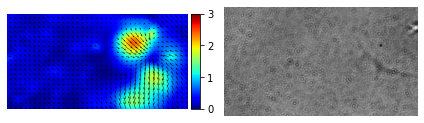

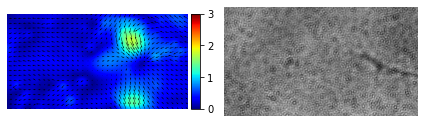

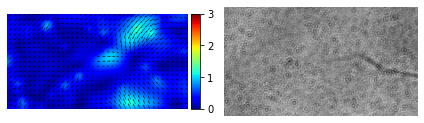

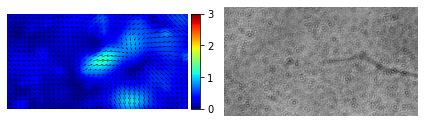

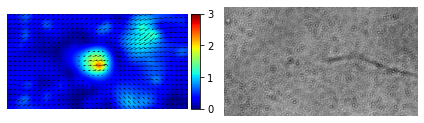

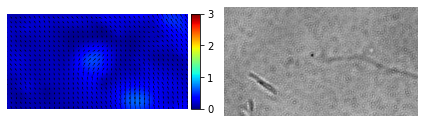

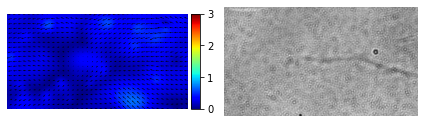

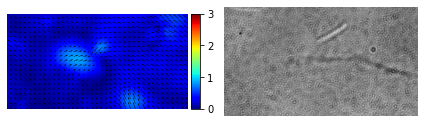

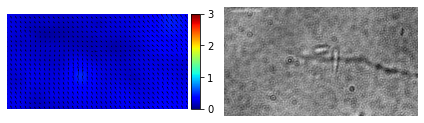

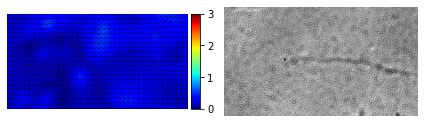

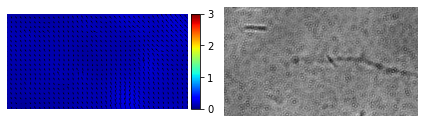

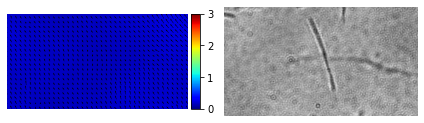

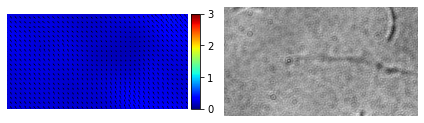

In [7]:
for frame in range(len(log1)):
    plot(log1, frame=frame, vmax=3)

# Example 2

Usage using an image and reference with an ROI. This can help approximating the noise 

In [8]:
pix_per_mu = 9.8138
E = 1000 # Young's modulus in Pa

img_path = '../data/example2/1kPa-2-Position006.tif'
ref_path = '../data/example2/1kPa-2-Position006_ref.tif'
roi_path = '../data/example2/1kPa-2-Position006.roi'

This time we are going to load in a ```.roi``` file from ImageJ. It is also possible to use a ```.csv``` with headers `x` and `y`. We can load in the `roi` by passing the `roi_path` the `load_data` method.

In [9]:
traction_obj = TractionForce(pix_per_mu, E=E, window_size=64)
img, ref, roi = traction_obj.load_data(img_path, ref_path, roi_path)

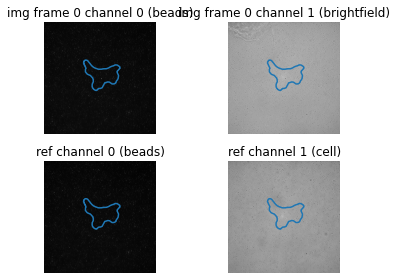

In [10]:
x, y = roi # get x and y from ROI

fig, ax = plt.subplots(2,2)
ax[0,0].set_title('img frame 0 channel 0 (beads)')
ax[0,0].imshow(img[0,0,:,:], cmap='gray')
ax[0,0].plot(x,y)
ax[0,0].set_axis_off()

ax[0,1].set_title('img frame 0 channel 1 (brightfield)')
ax[0,1].imshow(img[0,1,:,:], cmap='gray')
ax[0,1].plot(x,y)
ax[0,1].set_axis_off()

ax[1,0].set_title('ref channel 0 (beads)')
ax[1,0].imshow(ref[0,:,:], cmap='gray')
ax[1,0].plot(x,y)
ax[1,0].set_axis_off()

ax[1,1].set_title('ref channel 1 (cell)')
ax[1,1].imshow(ref[1,:,:], cmap='gray')
ax[1,1].plot(x,y)
ax[1,1].set_axis_off()

plt.tight_layout()

We can now process the stack to get the TFM results. The only difference between the previous example is that now we can pass the `roi` paramter into `process_stack`

In [11]:
log2 = traction_obj.process_stack(img, ref, roi=roi, verbose=1)

Processing stacks


/Users/ryan/miniconda3/envs/pytraction/lib/python3.8/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/Users/ryan/miniconda3/envs/pytraction/lib/python3.8/site-packages/scipy/optimize/optimize.py:1971: ComplexWarning: Casting complex values to real discards the imaginary part
  print("%5.0f   %12.6g %12.6g %s" % (fmin_data + (step,)))
/Users/ryan/miniconda3/envs/pytraction/lib/python3.8/site-packages/scipy/optimize/optimize.py:2015: ComplexWarning: Casting complex values to real discards the imaginary part
  print("%5.0f   %12.6g %12.6g %s" % (fmin_data + (step,)))


Since, we have provided an ROI file we can choose to make our traction map in the plot function.

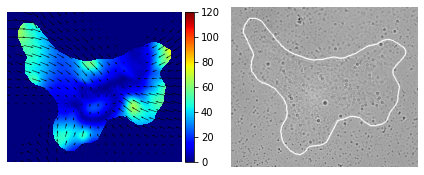

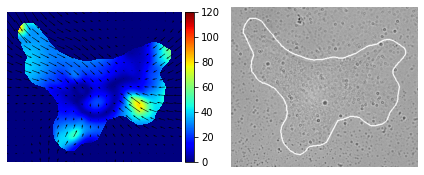

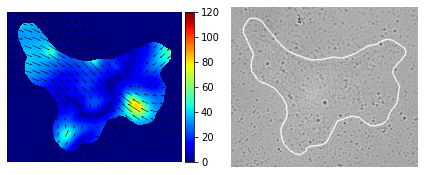

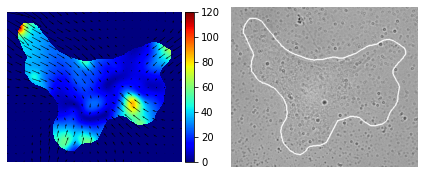

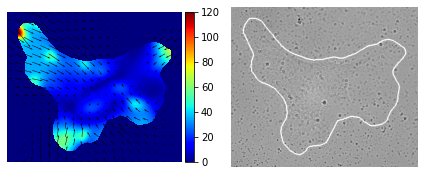

In [12]:
for frame in range(len(log2)):
    plot(log2, frame=frame, vmax=120, mask=True)

# Example 3

In the examples so far, we have shown how to compute the traction maps with images in the ideal format. In Example 3 we will demonstrate how you can process data with different input dimensions. We also make use of an experimental feature that predicts the ROI.

In [14]:
pix_per_mu = 1
E = 3000 # Young's modulus in Pa

img_path_bead = '../data/example3/Beads3.tif'
img_path_cell = '../data/example3/Cell3.tif'
ref_path = '../data/example3/BeadsStop.tif'

traction_obj = TractionForce(pix_per_mu, E=E, segment=True, window_size=16)
img, ref, roi = traction_obj.load_data(img_path_bead, ref_path)

RuntimeWarning: Please ensure that the input image has shape (f,c,w,h) the current shape is (11, 512, 512)

Notice that when we try to load the data we get a RuntimeWarning because the input shape is not correct.

In [15]:
img_bead = io.imread(img_path_bead)
img_cell = io.imread(img_path_cell)
ref = io.imread(ref_path)

print(f'The shape of the bead image is {img_bead.shape}')
print(f'The shape of the cell image is {img_cell.shape}')
print(f'The shape of the reference image is {ref.shape}')

The shape of the bead image is (11, 512, 512)
The shape of the cell image is (11, 512, 512)
The shape of the reference image is (11, 512, 512)


All the images have 11 dimentions which could be a stack in space or time. 

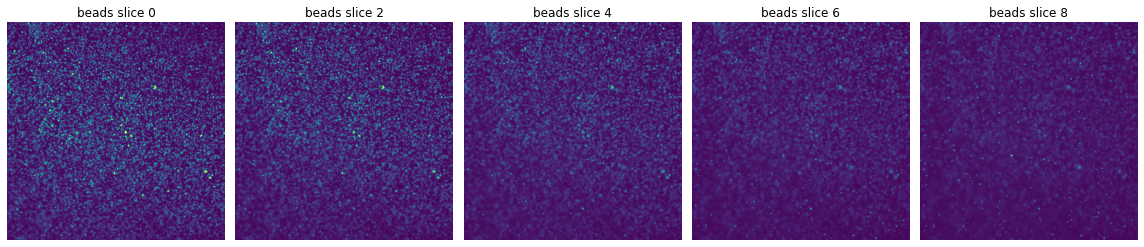

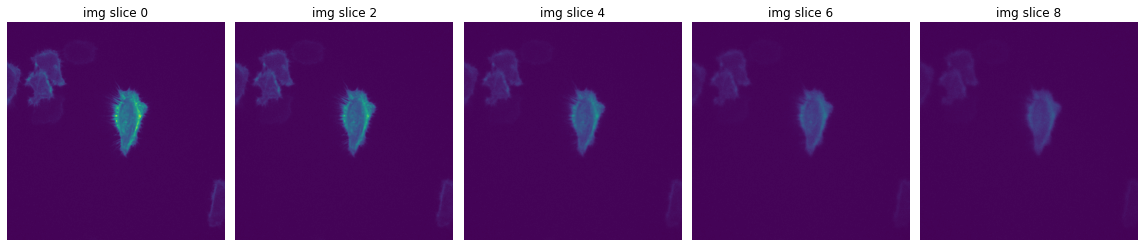

In [16]:
# plot every 2 bead slices
fig, ax = plt.subplots(1,5, figsize=(16,16))
for idx, axi in enumerate(ax.ravel()):
    axi.set_title(f'beads slice {idx*2}')
    axi.imshow(img_bead[idx*2,:,:], vmax=42168)
    axi.set_axis_off()
plt.tight_layout()

# plot every 2 cell slices
fig, ax = plt.subplots(1,5, figsize=(16,16))
for idx, axi in enumerate(ax.ravel()):
    axi.set_title(f'img slice {idx*2}')
    axi.imshow(img_cell[idx*2,:,:], vmax=42168)
    axi.set_axis_off()
plt.tight_layout()

The intensit of both images decays as the number of slices increase and the beads become out of focus which suggests theses are z slices. Therefore, we should take the maximum Z projection of the stack in the 0th axis to get a (w,h) shaped image. We should then stack the bead and cell image together. 

In [17]:
def z_project(img_path):
    img = io.imread(img_path)
    img_max= np.max(img, axis=0)
    return img_max

bead = z_project(img_path_bead)
cell = z_project(img_path_cell)
ref = z_project(ref_path)

img = np.stack([[bead, cell]])
ref = np.stack([ref, ref])

print(f'The shape of the bead image is {img.shape}')
print(f'The shape of the cell image is {ref.shape}')

The shape of the bead image is (1, 2, 512, 512)
The shape of the cell image is (2, 512, 512)


The images now have the correct shapes. Notice that I used `np.stack([[bead, cell]])` for the `img` to ensure the shape is `(1, 2, 512, 512)`. Let's save the images to disk and reload them using `load_data`

In [18]:
# save images to disk
io.imsave('../data/example3/tfm.tif', img)
io.imsave('../data/example3/tfm-ref.tif', ref)

In [19]:
pix_per_mu = 1
E = 3000 # Young's modulus in Pa

img_path = '../data/example3/tfm.tif'
ref_path = '../data/example3/tfm-ref.tif'

traction_obj = TractionForce(pix_per_mu, E=E, segment=True, window_size=16)
img, ref, _ = traction_obj.load_data(img_path, ref_path)

This time no error message was returned. I also set `segment=True` which will have used an experimental feature to predict the ROI. Let's run the stack.

In [20]:
log3 = traction_obj.process_stack(img, ref, verbose=1)

Processing stacks


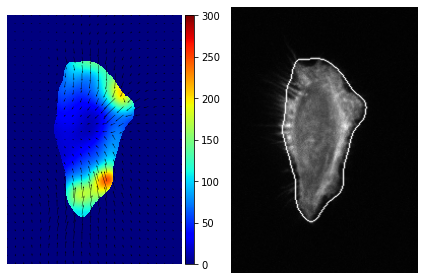

In [21]:
for frame in range(len(log3)):
    plot(log3, frame=frame, vmax=300, mask=True)

Note that no ROI was provided, and it was still possible to use the segment feature to locate the cell. If you are experiencing issues with this feature please raise an issue on the GitHub as this will allow us to update the feature.

Text(0.5, 1.0, 'Auto-segment image')

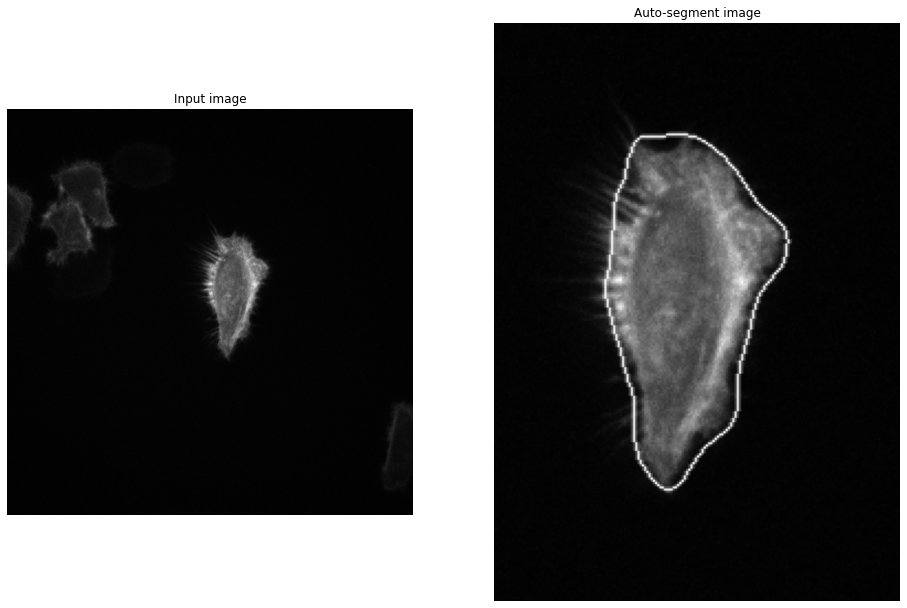

In [22]:
fig, ax = plt.subplots(1,2, figsize=(16,16))
ax[0].imshow(img[0,1,:,:], cmap='gray')
ax[0].set_axis_off()
ax[0].set_title('Input image')

ax[1].imshow(log3['cell_roi'][0], cmap='gray')
ax[1].set_axis_off()
ax[1].set_title('Auto-segment image')